In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

d:\softwares\Python\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\softwares\Python\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\softwares\Python\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "new/images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3583 files belonging to 28 classes.


In [4]:
class_names = dataset.class_names
class_names

['0',
 '1',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[26 22 17 20 19 20 22 16 13 16 26 22 10 21 18 16 17 12 22 10 20 26 13 27
 19 19 13 12 17 26 13 10]


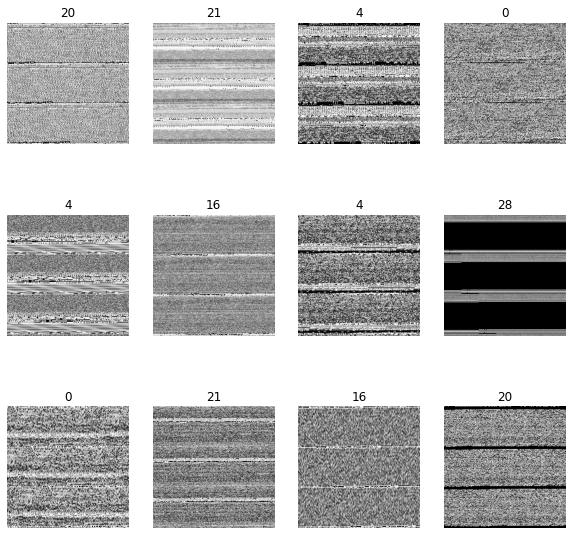

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

112

In [8]:
train_size = 0.8
len(dataset)*train_size

89.60000000000001

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

58

In [11]:
val_size=0.1
len(dataset)*val_size

11.200000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

52

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

89

In [17]:
len(val_ds)

11

In [18]:
len(test_ds)

12

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 28

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 224, 224, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 222, 222, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 111, 111, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 109, 109, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 54, 54, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 52, 52, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 26, 26, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
89/89 [==============================] - 195s 2s/step - loss: 3.1250 - accuracy: 0.0854 - val_loss: 3.0816 - val_accuracy: 0.0938
Epoch 2/50
89/89 [==============================] - 133s 1s/step - loss: 3.0439 - accuracy: 0.0938 - val_loss: 3.0516 - val_accuracy: 0.0994
Epoch 3/50
89/89 [==============================] - 156s 2s/step - loss: 3.0409 - accuracy: 0.0998 - val_loss: 3.0558 - val_accuracy: 0.0938
Epoch 4/50
89/89 [==============================] - 166s 2s/step - loss: 3.0360 - accuracy: 0.0941 - val_loss: 3.0526 - val_accuracy: 0.1051
Epoch 5/50
89/89 [==============================] - 162s 2s/step - loss: 3.0357 - accuracy: 0.0962 - val_loss: 3.0467 - val_accuracy: 0.1023
Epoch 6/50
89/89 [==============================] - 150s 2s/step - loss: 3.0303 - accuracy: 0.0976 - val_loss: 3.0496 - val_accuracy: 0.0767
Epoch 7/50
89/89 [==============================] - 151s 2s/step - loss: 3.0305 - accuracy: 0.1019 - val_loss: 3.0467 - val_accuracy: 0.0938
Epoch 8/50
89

In [27]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 7s 189ms/step - loss: 3.0068 - accuracy: 0.0888
